### Variable Correlation Analysis 

##### Find features of interest for further analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
# Load in local csv
folder = '/root/capsule/data/filtered_data_20240911/filtered_data_20240911.csv'
df = pd.read_csv(folder)

df['session_end_time'] = pd.to_datetime(df['session_end_time'])

df['session_end_time'] = df['session_end_time'].dt.date

df.head()

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,water_after_session_last_session,location,session_name,creation_time,subject_genotype,probes,results,results_location,session_time,docDB_status
0,730942,2024-09-10,181826,14.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
1,741211,2024-09-10,181707,14.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741211_2024-09-10_18-17-07,2024-09-10T18:17:07-07:00,wt/wt,[],NaN,NaN,18-17-07,1_uploaded but not processed
2,736198,2024-09-10,181446,14.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_73...,behavior_736198_2024-09-10_18-14-46,2024-09-10T18:14:46-07:00,wt/wt,[],NaN,NaN,18-14-46,1_uploaded but not processed
3,730945,2024-09-10,181112,14.0,447-2-B,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
4,741213,2024-09-10,180831,14.0,447-2-A,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741213_2024-09-10_18-08-31,2024-09-10T18:08:31-07:00,wt/wt,[],NaN,NaN,18-08-31,1_uploaded but not processed


In [3]:
# All columns in df
print(df.columns.tolist())  

['subject_id', 'session_date', 'nwb_suffix', 'session', 'rig', 'user_name', 'curriculum_name', 'curriculum_version', 'current_stage_actual', 'task', 'notes', 'experiment_description', 'session_start_time', 'session_end_time', 'session_run_time_in_min', 'water_in_session_foraging', 'water_in_session_manual', 'water_in_session_total', 'water_after_session', 'water_day_total', 'base_weight', 'target_weight', 'target_weight_ratio', 'weight_after', 'laser_1_calibration_power', 'laser_2_calibration_power', 'laser_1_target_areas', 'laser_2_target_areas', 'commit_ID', 'repo_url', 'current_branch', 'weight_after_ratio', 'p_reward_sum_mean', 'p_reward_sum_std', 'p_reward_sum_median', 'p_reward_contrast_mean', 'p_reware_contrast_median', 'effective_block_length_mean', 'effective_block_length_std', 'effective_block_length_median', 'effective_block_length_min', 'effective_block_length_max', 'duration_gocue_stop_mean', 'duration_gocue_stop_std', 'duration_gocue_stop_median', 'duration_gocue_stop_min

In [4]:
# Check NaN values

nan_count = df.isnull().sum()

max_nan = nan_count.idxmax()
max_nan_count = nan_count.max()

nan_count = nan_count[nan_count > 0]

threshold = 1000

above_threshold_nan = nan_count[nan_count > threshold]

print(f'Above threshold: {above_threshold_nan}')

Above threshold: curriculum_name              1822
curriculum_version           1822
current_stage_actual         1822
notes                        2320
experiment_description       3763
laser_1_calibration_power    3666
laser_2_calibration_power    3665
laser_1_target_areas         3651
laser_2_target_areas         3650
commit_ID                    1744
repo_url                     1744
current_branch               1744
curriculum_schema_version    1822
location                     3022
session_name                 3022
creation_time                3022
subject_genotype             3022
probes                       3022
results                      3354
results_location             3354
session_time                 3022
dtype: int64


In [5]:
data = df['foraging_eff']

n = len(data)

# Use scott's rule

bin_width = 3.5 * np.std(data) * n**(-1/3)

n_bins = int(np.ceil((np.max(data) - np.min(data)) / bin_width))

In [6]:
# List of distributions to check
distributions = [stats.norm, stats.gamma, stats.lognorm, stats.expon]

# Fit each distribution
results = []
for dist in distributions:
    params = dist.fit(data)
    D, p = stats.kstest(data, dist.name, args=params)
    results.append((dist.name, p))

# Sort results by p-value
results.sort(key=lambda x: x[1], reverse=True)

print("Distribution fitting results:")
for name, p in results:
    print(f"{name}: p-value = {p}")

/opt/conda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6554: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


Distribution fitting results:
norm: p-value = 6.913795107649228e-08
lognorm: p-value = 6.6233110984743e-09
gamma: p-value = 8.900125628540165e-17
expon: p-value = 0.0


/opt/conda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6554: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


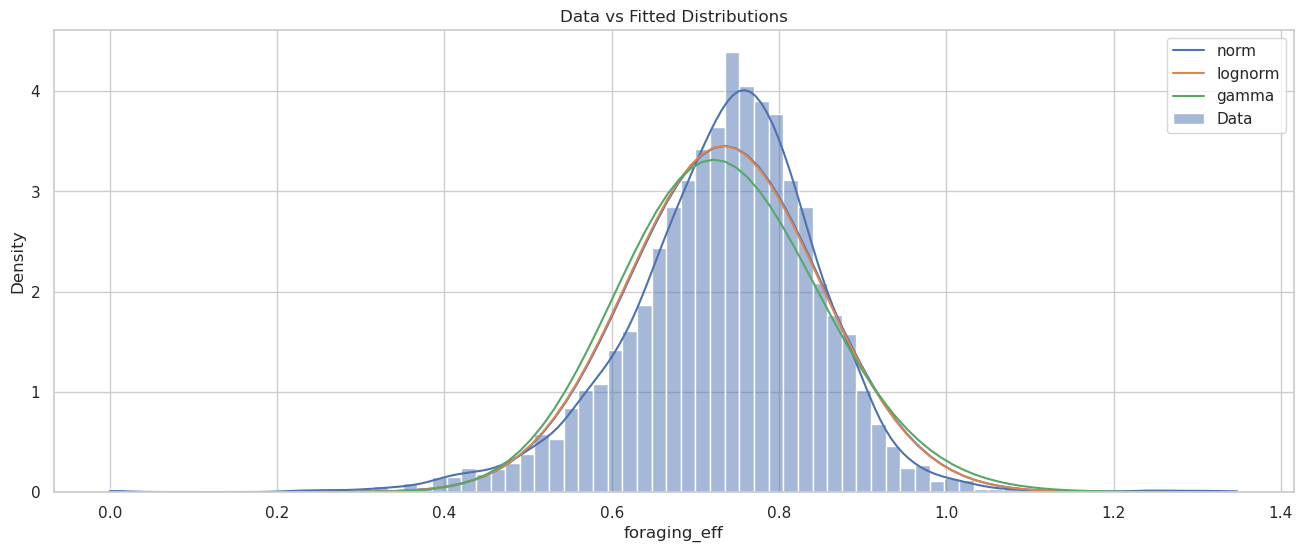

Skewness: -0.4243470447579627
Kurtosis: 2.4136182779152353


In [7]:
# Foraging Efficiency Distribution - normally distributed gausssian 

sns.set_theme()
sns.set_style("whitegrid")

plt.figure(figsize=(16, 6))
sns.histplot(data, kde=True, stat="density", label="Data")

# Plot PDFs of top 3 fitted distributions
x = np.linspace(data.min(), data.max(), 100)
for name, _ in results[:3]:
    dist = getattr(stats, name)
    params = dist.fit(data)
    pdf = dist.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
    plt.plot(x, pdf, label=name)

plt.legend()
plt.title("Data vs Fitted Distributions")
plt.show()

# Check skew and kurtosis of data 
print(f'Skewness: {data.skew()}')
print(f'Kurtosis: {data.kurtosis()}')

In [8]:
# Main df is just to keep track of what I think is interesting 
main_df = df[['subject_id', 'curriculum_name', 'current_stage_actual', 'session_end_time', 'subject_genotype','session_run_time_in_min', 'p_reward_sum_mean', 'effective_block_length_mean', 'duration_gocue_stop_mean', 'duration_delay_period_mean', 'duration_iti_mean', 'finished_rate', 'reward_rate', 'foraging_eff', 'reaction_time_mean', 'avg_trial_length_in_seconds']]

main_df = main_df.dropna().copy()

# By sub selecting these variables, decreasing the sample size significantly, will affect model

variable_corr_df = main_df[(main_df['curriculum_name'] == 'Uncoupled Baiting') & (df['current_stage_actual'] == 'GRADUATED')][['subject_id', 'session_end_time', 'foraging_eff', 'session_run_time_in_min', 'p_reward_sum_mean', 'effective_block_length_mean', 'duration_gocue_stop_mean', 'duration_delay_period_mean', 'duration_iti_mean', 'finished_rate', 'reward_rate', 'reaction_time_mean', 'avg_trial_length_in_seconds']]

print(variable_corr_df[['session_run_time_in_min', 'finished_rate', 'effective_block_length_mean', 'p_reward_sum_mean', 'duration_gocue_stop_mean', 'duration_delay_period_mean', 'duration_iti_mean', 'finished_rate', 'reward_rate', 'reaction_time_mean', 'avg_trial_length_in_seconds']].describe())


       session_run_time_in_min  finished_rate  effective_block_length_mean  \
count                42.000000      42.000000                    42.000000   
mean                 75.357143       0.907764                    17.192336   
std                  11.495113       0.127892                     2.039754   
min                  38.000000       0.369565                    14.400000   
25%                  75.000000       0.866505                    15.894725   
50%                  75.000000       0.956178                    16.727778   
75%                  80.000000       0.990341                    17.491071   
max                  90.000000       1.000000                    22.363636   

       p_reward_sum_mean  duration_gocue_stop_mean  \
count          42.000000                 42.000000   
mean            0.815652                  3.299493   
std             0.047963                  0.132477   
min             0.678672                  3.159613   
25%             0.778544   

/tmp/ipykernel_10716/1426339165.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_corr_df = main_df[(main_df['curriculum_name'] == 'Uncoupled Baiting') & (df['current_stage_actual'] == 'GRADUATED')][['subject_id', 'session_end_time', 'foraging_eff', 'session_run_time_in_min', 'p_reward_sum_mean', 'effective_block_length_mean', 'duration_gocue_stop_mean', 'duration_delay_period_mean', 'duration_iti_mean', 'finished_rate', 'reward_rate', 'reaction_time_mean', 'avg_trial_length_in_seconds']]


In [9]:
variable_corr_df.head()

,subject_id,session_end_time,foraging_eff,session_run_time_in_min,p_reward_sum_mean,effective_block_length_mean,duration_gocue_stop_mean,duration_delay_period_mean,duration_iti_mean,finished_rate,reward_rate,reaction_time_mean,avg_trial_length_in_seconds
1,741211,2024-09-10,0.768945,75,0.853073,16.500000,3.190522,1.242515,3.880825,0.988827,0.517891,0.171070,8.379888
2,736198,2024-09-10,0.708424,75,0.808876,15.333333,3.346972,1.518895,3.937447,0.988166,0.459082,0.328705,8.875740
4,741213,2024-09-10,0.740106,75,0.755513,17.333333,3.219867,1.104705,4.171514,0.998099,0.459048,0.208005,8.555133
22,741211,2024-09-09,0.707968,75,0.810654,17.166667,3.159613,1.255320,3.929457,1.000000,0.459813,0.149519,8.411215
25,736198,2024-09-09,0.778647,75,0.854274,15.612903,3.447830,1.515321,3.915232,0.946322,0.518908,0.405383,8.946322


In [10]:
# Data preprocessing 

# Separate features and foraging efficiency 

X = variable_corr_df.drop(['foraging_eff', 'subject_id', 'session_end_time'], axis=1)
y = variable_corr_df['foraging_eff']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index) # create new scaled dataframe 

X_scaled.head()

,session_run_time_in_min,p_reward_sum_mean,effective_block_length_mean,duration_gocue_stop_mean,duration_delay_period_mean,duration_iti_mean,finished_rate,reward_rate,reaction_time_mean,avg_trial_length_in_seconds
1,-0.031446,0.789648,-0.343535,-0.832532,-0.857630,-1.175935,0.641520,0.296019,-0.726693,-1.309525
2,-0.031446,-0.142993,-0.922433,0.362738,0.231494,-0.719613,0.636288,-0.625929,1.594643,0.044661
4,-0.031446,-1.269046,0.069963,-0.608337,-1.400698,1.166788,0.714898,-0.626466,-0.182778,-0.830926
22,-0.031446,-0.105464,-0.012737,-1.068677,-0.807173,-0.784002,0.729944,-0.614466,-1.044054,-1.223971
25,-0.031446,0.815007,-0.783711,1.133293,0.217408,-0.898644,0.305142,0.311959,2.723803,0.237424


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:           foraging_eff   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     390.0
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           2.32e-22
Time:                        21:02:38   Log-Likelihood:                 118.34
No. Observations:                  33   AIC:                            -214.7
Df Residuals:                      22   BIC:                            -198.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Coefficients: 
 const                          0.757400
session_run_time_in_min        0.002810
p_reward_sum_mean             -0.030823
effective_block_length_mean   -0.003479
duration_gocue_stop_mean      -0.042472
duration_delay_period_mean    -0.000336
duration_iti_mean             -0.000817
finished_rate                 -0.029610
reward_rate                    0.094050
reaction_time_mean             0.021041
avg_trial_length_in_seconds   -0.002264
dtype: float64


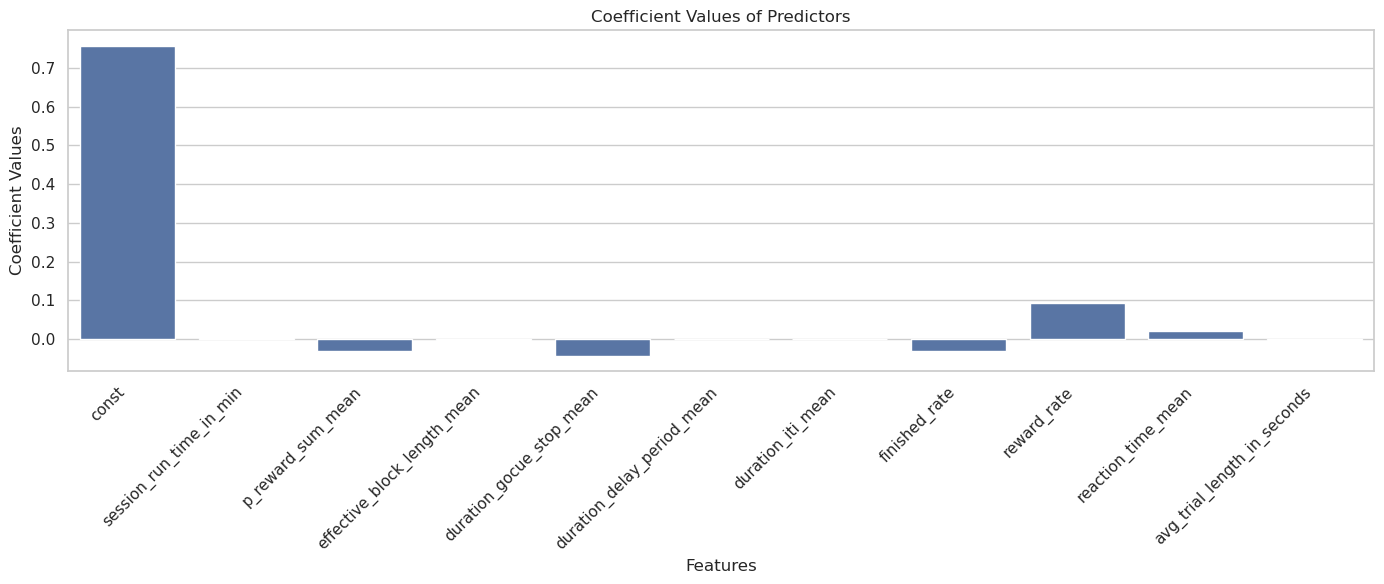

In [12]:
coeffs = ols_model.params
print(f"Coefficients: \n {coeffs}")

coeff_df = pd.DataFrame({'column': coeffs.index, 'coeffs': coeffs.values})


plt.figure(figsize=(14, 6))
sns.barplot(x='column', y='coeffs', data=coeff_df)

plt.title('Coefficient Values of Predictors')
plt.xlabel('Features')
plt.ylabel('Coefficient Values')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

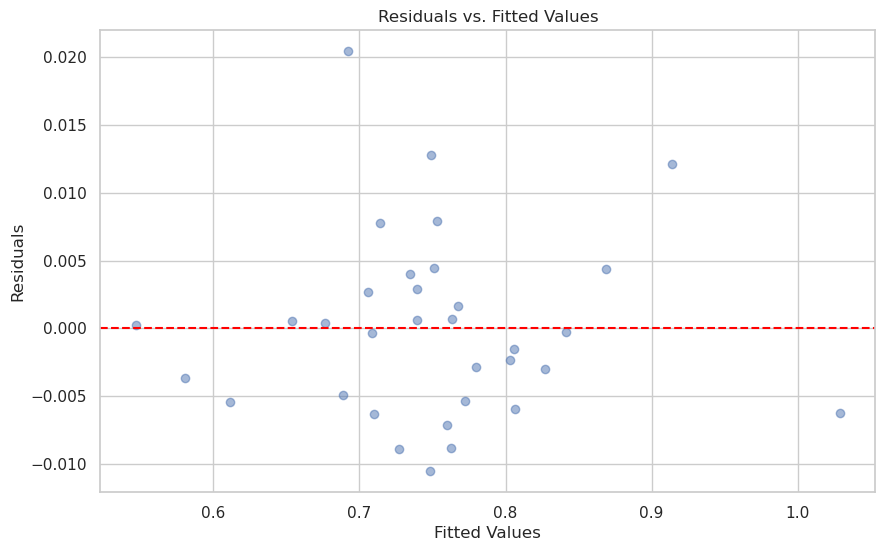

In [13]:
# Plot residuals 

residuals = ols_model.resid
fitted_values = ols_model.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Adds a horizontal line at zero
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()